In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import urllib.request
import gensim

from konlpy.tag import Okt
from konlpy.tag import Mecab
from collections import Counter
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt') #데이터 읽기
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt') #데이터 읽기

train_data.head() #훈련 데이터 확인

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] #조사를 불용어로지정

#데이터 가공
def load_data(train_data, test_data, num_words=10000):
    #중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True) 
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
  
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist): #사전 구성
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
#RNN모델
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [6]:
#1-D CNN 모델
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_1dcnn = tf.keras.Sequential()
model_1dcnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1dcnn.add(tf.keras.layers.MaxPooling1D(5))
model_1dcnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1dcnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_1dcnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_1dcnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1dcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [7]:
#GlobalMaxPooling1D 모델
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [8]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

In [9]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}

word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2 
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(x_train.shape) #훈련데이터의 크기

(25000, 580)


In [12]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건(25000(Total_data) - 10000(Train_data) = 15000(Test_data))
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [13]:
#RNN모델 학습 시작
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 4s 45ms/step - loss: 0.6931 - accuracy: 0.5093 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6928 - accuracy: 0.5091 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 3/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6925 - accuracy: 0.5105 - val_loss: 0.6929 - val_accuracy: 0.5011
Epoch 4/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6914 - accuracy: 0.5143 - val_loss: 0.6922 - val_accuracy: 0.5015
Epoch 5/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6875 - accuracy: 0.5138 - val_loss: 0.6899 - val_accuracy: 0.5068
Epoch 6/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6781 - accuracy: 0.5301 - val_loss: 0.7241 - val_accuracy: 0.5110
Epoch 7/20
30/30 [==============================] - 1s 28ms/step - loss: 0.7028 - accuracy: 0.5467 - val_loss: 0.6930 - val_accuracy: 0.5121
Epoch 8/20
30

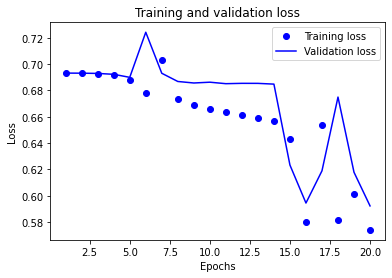

In [14]:
#RNN모델의 학습 Loss와 accuracy 그래프
history_rnn = history_rnn.history
acc = history_rnn['accuracy']
val_acc = history_rnn['val_accuracy']
loss = history_rnn['loss']
val_loss = history_rnn['val_loss']

epochs = range(1, len(acc) + 1)
#Training loss and Validation loss Graph
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

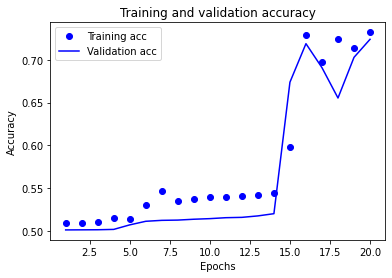

In [15]:
#Training accuracy and Validation accuracy graph
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
#1-D CNN모델 학습 시작
model_1dcnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1dcnn = model_1dcnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 28ms/step - loss: 0.6929 - accuracy: 0.5175 - val_loss: 0.6922 - val_accuracy: 0.4957
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.6867 - accuracy: 0.5799 - val_loss: 0.6834 - val_accuracy: 0.6863
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.6453 - accuracy: 0.7550 - val_loss: 0.5715 - val_accuracy: 0.7916
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.4267 - accuracy: 0.8443 - val_loss: 0.3469 - val_accuracy: 0.8546
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2537 - accuracy: 0.8999 - val_loss: 0.3146 - val_accuracy: 0.8678
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1735 - accuracy: 0.9406 - val_loss: 0.3221 - val_accuracy: 0.8686
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1218 - accuracy: 0.9639 - val_loss: 0.3422 - val_accuracy: 0.8664
Epoch 8/20
30

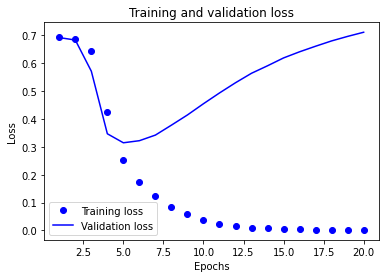

In [17]:
history_1dcnn = history_1dcnn.history
acc = history_1dcnn['accuracy']
val_acc = history_1dcnn['val_accuracy']
loss = history_1dcnn['loss']
val_loss = history_1dcnn['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

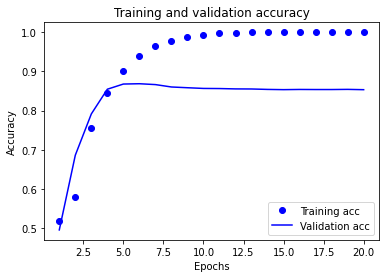

In [18]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
#GlobalMaxPooling1D 모델 학습 시작
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 1s 11ms/step - loss: 0.6916 - accuracy: 0.5038 - val_loss: 0.6889 - val_accuracy: 0.5216
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.6828 - accuracy: 0.6331 - val_loss: 0.6764 - val_accuracy: 0.6684
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.6627 - accuracy: 0.7215 - val_loss: 0.6520 - val_accuracy: 0.6939
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.6276 - accuracy: 0.7435 - val_loss: 0.6131 - val_accuracy: 0.7595
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.5791 - accuracy: 0.8023 - val_loss: 0.5669 - val_accuracy: 0.7807
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.5261 - accuracy: 0.8271 - val_loss: 0.5211 - val_accuracy: 0.8061
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.4751 - accuracy: 0.8409 - val_loss: 0.4801 - val_accuracy: 0.8188
Epoch 8/20
30/30 [=

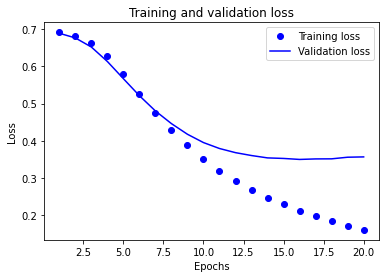

In [20]:
history_gmp = history_gmp.history
acc = history_gmp['accuracy']
val_acc = history_gmp['val_accuracy']
loss = history_gmp['loss']
val_loss = history_gmp['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

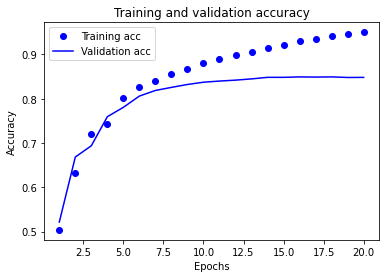

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [23]:
#제시한 단어와 비슷한 단어를 찾기
word2vec.similar_by_word("사랑")

/tmp/ipykernel_3761/2221278766.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [24]:
#Word2Vec 모델로 학습 시키기
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_3761/2211409140.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:


In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

#모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [26]:
#학습 시작
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=25  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. --- > 훈련 데이터의 값이 26번째부터 안정적으로 1이 되므로 값을 줄여도 됨

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/25
15/15 - 1s - loss: 0.6889 - accuracy: 0.6391 - val_loss: 0.6817 - val_accuracy: 0.7955
Epoch 2/25
15/15 - 1s - loss: 0.6711 - accuracy: 0.8127 - val_loss: 0.6602 - val_accuracy: 0.8351
Epoch 3/25
15/15 - 1s - loss: 0.6373 - accuracy: 0.8649 - val_loss: 0.6176 - val_accuracy: 0.8619
Epoch 4/25
15/15 - 1s - loss: 0.5745 - accuracy: 0.8904 - val_loss: 0.5486 - val_accuracy: 0.8652
Epoch 5/25
15/15 - 1s - loss: 0.4862 - accuracy: 0.9017 - val_loss: 0.4662 - val_accuracy: 0.8705
Epoch 6/25
15/15 - 1s - loss: 0.3910 - accuracy: 0.9101 - val_loss: 0.3921 - val_accuracy: 0.8797
Epoch 7/25
15/15 - 1s - loss: 0.3106 - accuracy: 0.9173 - val_loss: 0.3393 - val_accuracy: 0.8812
Epoch 8/25
15/15 - 1s - loss: 0.2512 - accuracy: 0.9283 - val_loss: 0.3082 - val_accuracy: 0.8844
Epoch 9/25
15/15 - 1s - loss: 0.2082 - accuracy: 0.9391 - val_loss: 0.2904 - val_accuracy: 0.8866
Epoch 10/25
15/15 - 1s - loss: 0.1753 - accuracy: 0.9495 - val_loss: 0.2799 - val_accuracy: 0.8879
Epoch 11/25
15/15 -

In [27]:
#모델의 결과값
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.3266 - accuracy: 0.8741
[0.3265533149242401, 0.8740800023078918]


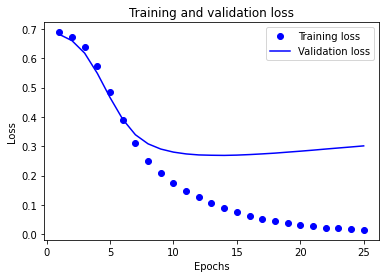

In [28]:
#모델의 결과값을 그래프로 표시
history = history.history
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

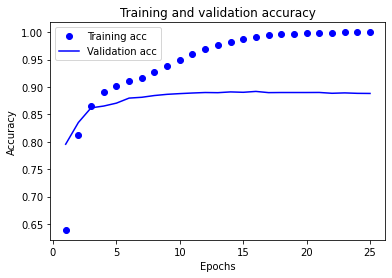

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
#[E-06] 회고
#프로젝트를 진행하며 어려웠던 점
#==> 마지막으로 했던 모델의 값을 0.85이상으로 맞추는 것이 매우 어려웠다. 이를 해결하기 위해 처음에는 verbos, epoch, batch size를 변경하였으나
#    운이 좋게 한번 0.85가 넘었지만 일시적인 것이 였고 나머지는 기준값을 넘지 못했다. 다음에는 밑에 history표를 보며 값의 안정성을 생각하여
#    verbos의 값을 늘려 평균을 통해 마구 튀지않는 값을 도출 했지만 근본적인 해결책은 되지 않았다. 그리고 데이터의 훈련갯수와 검증갯수를 변경해
#    보았지만 유효한 방법은 아니였다. 이를 해결한 것은 모델의 구성을 변경하는 것이였는데 위에 있는 1-D CNN , RNN, GlobalMaxPooling1D 중 가장
#    안정적이고 높은 정확도를 가진 1-D CNN 모델의 구성을 채용하였고 결과적으로 기준값을 넘는 결과를 도출하였다.
#
#프로젝트를 진행하며 모호한 점
#==> 단순한 궁금증이지만 위의 3개의 모델중 RNN이 유독 낮은 정확도를 보였는데 이를 아직 정확하게 이해하지 못해 모호한 상태이다. 내가 구조를
#    아직 정확히 알지 못해 이런것이지 아니면 RNN 의 특성에 의해 이렇게 낮은 정확도가 나오는 것인지 추후 확인이 필요하다.
#
# 자기다짐
#==> 오랫동안 같은 코드를 보며 그리고 비슷한 과정을 보며 처음과 다르게 어렴풋이 흐름이 보이는 것 같아 성장한 느낌이 든다. 하지만 아직 코드와 모델의
#    실체를 정확히 보지 못하기에 많은 모델과 경우를 접하며 이해도와 경험을 쌓아야 한다는 생각이든다.